# Waste Recognition for BinIT

In this notebook, we're trying to make a model to classify waste images into 3 classes:
- Organic
- Recycle
- Hazardous

We have collected each classes with the amount of 1000+ images from existing dataset online and google searching. We have done the data cleaning, so in the first part of this notebook will be converting the images into a dataframe.

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.applications.mobilenet_v2 as mobilenetv2
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import Lambda, Activation, GlobalAveragePooling2D
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Specifying the image properties
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Defining dataset paths and categories
base_path = "/kaggle/input/capstone-waste-classification-dataset/Dataset"
organic_path = os.path.join(base_path, 'Organic')
recycle_path = os.path.join(base_path, 'Recycle')
hazardous_path = os.path.join(base_path, 'Hazardous')
categories = {0: 'organic', 1: 'recycle', 2: 'hazardous'}

## Create the dataframe

In [4]:
images = []
labels = []

for img in os.listdir(organic_path):
    images.append(os.path.join(organic_path, img))
    labels.append('0')
    
for img in os.listdir(recycle_path):
    images.append(os.path.join(recycle_path, img))
    labels.append('1')
    
for img in os.listdir(hazardous_path):
    images.append(os.path.join(hazardous_path, img))
    labels.append('2')

In [5]:
df = pd.DataFrame({'filename': images, 
                   'category': labels
                 })

df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filename,category
0,/kaggle/input/capstone-waste-classification-da...,0
1,/kaggle/input/capstone-waste-classification-da...,1
2,/kaggle/input/capstone-waste-classification-da...,2
3,/kaggle/input/capstone-waste-classification-da...,2
4,/kaggle/input/capstone-waste-classification-da...,0


In [6]:
df.tail()

,filename,category
3266,/kaggle/input/capstone-waste-classification-da...,1
3267,/kaggle/input/capstone-waste-classification-da...,0
3268,/kaggle/input/capstone-waste-classification-da...,0
3269,/kaggle/input/capstone-waste-classification-da...,2
3270,/kaggle/input/capstone-waste-classification-da...,0


## Create the Model

After trying couple of models, using MobileNet (combining with adjustment layers) produced the highest accuracy. Here, we imported the MobileNet only up to the block3expand relu layer.

In [7]:
mobilenetv2_layer = tf.keras.applications.MobileNetV2(include_top=False, 
                                                     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

mobilenetv2_layer.trainable = False
last_layer = mobilenetv2_layer.get_layer('block_3_expand_relu')
last_output = last_layer.output

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

In [9]:
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Lambda(mobilenetv2_preprocessing))
model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 3

## Define callback using EarlyStop

We use EarlyStopping to halt the training process when the validation accuracy has stopped improving.

In [10]:
early_stop = EarlyStopping(patience = 5, verbose = 1, monitor='val_categorical_accuracy', 
                           mode='max', min_delta=0.001, restore_best_weights = True)
callbacks = [early_stop]

## Split the dataset

Split data into training set, validation set, and test set using 80/10/10 proportion.

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('Train size = ', total_train, '|| Validation size = ', total_validate, '|| Test size = ', test_df.shape[0])

Train size =  2616 || Validation size =  458 || Test size =  197


## Training the model

Train the data using image generator

In [12]:
batch_size=64

train_datagen = image.ImageDataGenerator(    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', 
    batch_size=batch_size
)

Found 2614 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [13]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col= 'filename',
    y_col= 'category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 458 validated image filenames belonging to 3 classes.


In [14]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/tmp/ipykernel_28/2716048666.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
40/40 [==============================] - 70s 1s/step - loss: 0.4442 - categorical_accuracy: 0.8200 - val_loss: 0.1384 - val_categorical_accuracy: 0.9464
Epoch 2/20
40/40 [==============================] - 38s 939ms/step - loss: 0.1396 - categorical_accuracy: 0.9439 - val_loss: 0.1046 - val_categorical_accuracy: 0.9554
Epoch 3/20
40/40 [==============================] - 38s 954ms/step - loss: 0.1280 - categorical_accuracy: 0.9478 - val_loss: 0.1030 - val_categorical_accuracy: 0.9621
Epoch 4/20
40/40 [==============================] - 38s 947ms/step - loss: 0.1029 - categorical_accuracy: 0.9627 - val_loss: 0.1272 - val_categorical_accuracy: 0.9531
Epoch 5/20
40/40 [==============================] - 38s 949ms/step - loss: 0.0992 - categorical_accuracy: 0.9627 - val_loss: 0.1295 - val_categorical_accuracy: 0.9531
Epoch 6/20
40/40 [==============================] - 38s 939ms/step - loss: 0.0856 - categorical_accuracy: 0.9690 - val_loss: 0.0936 - val_categorical_accuracy: 0.9710
E

In [15]:
# Save model weights
model.save_weights("model.h5")

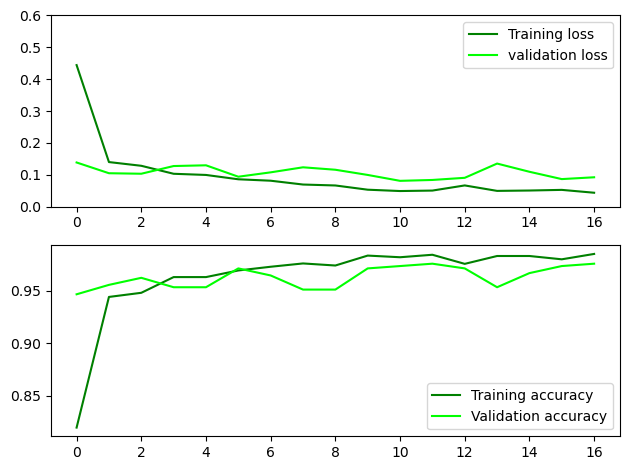

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='g', label="Training loss")
ax1.plot(history.history['val_loss'], color='lime', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='g', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='lime',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Evaluate Test

In [17]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col= 'filename',
    y_col= 'category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 197 validated image filenames belonging to 3 classes.


In [18]:
test_res = model.evaluate(test_generator)
print("Test accuracy:", test_res[1])

197/197 [==============================] - 3s 10ms/step - loss: 0.0590 - categorical_accuracy: 0.9797
Test accuracy: 0.9796954393386841


### Try classifying new data

In [19]:
def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_batch)
    predict_label = np.argmax(prediction)
    category = categories[predict_label]
    print(prediction)
    print(category)

path_img = '/kaggle/input/test-data-baru/botol plas.jpg'
classify(path_img)

1/1 [==============================] - 1s 1s/step
[[7.1709082e-06 5.9058708e-01 4.0940571e-01]]
recycle


### Convert the model into Tflite for deployment

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)